In [5]:
library(readr)
library(readxl)
library(tidyverse)
library(caret)
library(rpart)
library(MLmetrics)


In [6]:
train_data <- read_excel("C:/proje/train.xlsx")
test_data <- read_excel("C:/proje/test.xlsx")
sample_submission<- read.csv("C:/proje/sample_submission.csv")

In [7]:
train_data$date <- as.Date(paste(train_data$date,"-01",sep=""))
test_data$date <- as.Date(paste(test_data$date,"-01",sep=""))


In [8]:
train_data_sum <- train_data %>%
  group_by(customer,date,item) %>%
  summarize(sumorder = sum(order))

`summarise()` has grouped output by 'customer', 'date'. You can override using the `.groups` argument.



In [9]:
res <- merge(
  expand.grid(customer=unique(train_data_sum$customer), date=unique(train_data_sum$date),item=unique(train_data_sum$item)),
  train_data_sum, all=TRUE)
res$sumorder[is.na(res$sumorder)] <- 0

train_data_sum <- res
a <- train_data_sum %>%
  filter(item %in% as.numeric(levels(factor(train_data[train_data$customer=="A",]$item))) & customer == "A")
b <- train_data_sum %>%
  filter(item %in% as.numeric(levels(factor(train_data[train_data$customer=="B",]$item))) & customer == "B")
c <- train_data_sum %>%
  filter(item %in% as.numeric(levels(factor(train_data[train_data$customer=="C",]$item))) & customer == "C")

train_data_sum <- rbind(a,b,c)

In [10]:
train_data_sum$id <- NULL
train_data_sum$customer <- as.factor(train_data_sum$customer)
train_data_sum$item <- as.factor(train_data_sum$item)

test_data$id <- NULL
test_data$customer <- as.factor(test_data$customer)
test_data$item <- as.factor(test_data$item)

head(train_data_sum)

,customer,date,item,sumorder
,<fct>,<date>,<fct>,<dbl>
1,A,2018-01-01,0,216.0
2,A,2018-01-01,1,360.0
3,A,2018-01-01,2,1312.0
4,A,2018-01-01,3,3240.0
5,A,2018-01-01,4,734.4
6,A,2018-01-01,5,475.2


`summarise()` has grouped output by 'customer'. You can override using the `.groups` argument.



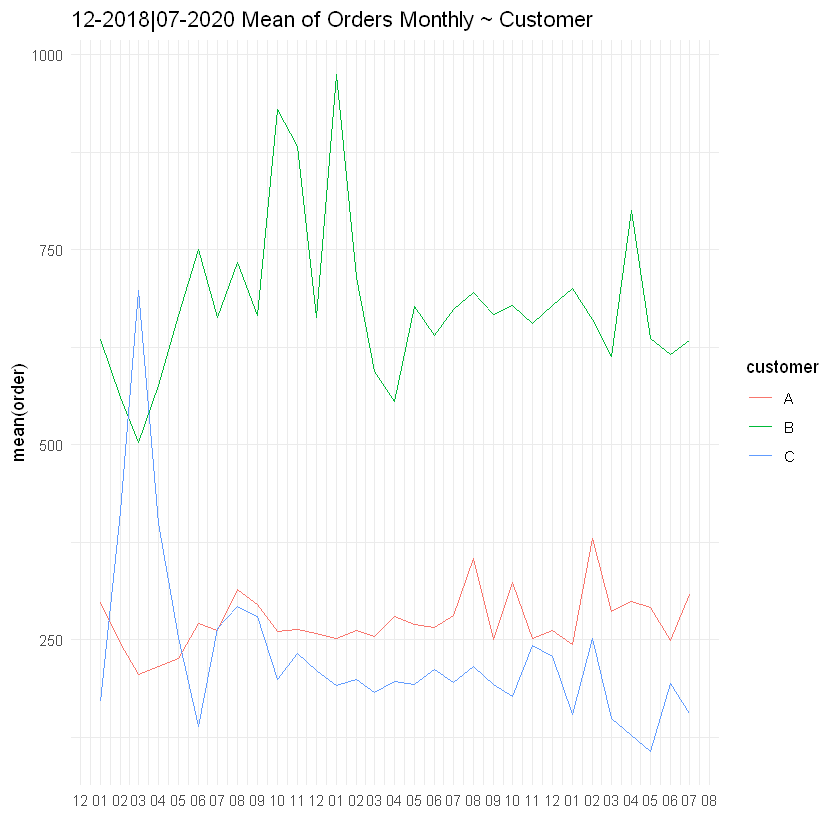

In [11]:
train_data %>%
  group_by(customer,date) %>%
  summarize(mean(order)) %>%
  ggplot(aes(x=date , y=`mean(order)`,fill = customer)) +
  geom_line(aes(color=customer)) +
  xlab("") +
  ggtitle("12-2018|07-2020 Mean of Orders Monthly ~ Customer") +
  scale_x_date(date_breaks = "1 month", date_labels = "%m") +
  theme_minimal()

In [12]:
set.seed(1234)

indeks <- createDataPartition(train_data_sum$sumorder, p=0.90,list=FALSE)
training <- train_data_sum[indeks,]
test <- train_data_sum[-indeks,]

train_x <- training %>% dplyr::select(-sumorder)
train_y <- training$sumorder

test_x <- test %>% dplyr::select(-sumorder)
test_y <- test$sumorder


In [13]:
# Linear Regression
lin_model <- lm(sumorder~.,data=training)
pred_lin_test <- predict(lin_model, test_x)
RMSE(y_pred = pred_lin_test,y_true = test_y)

Warning message in predict.lm(lin_model, test_x):
"prediction from a rank-deficient fit may be misleading"


[1] 1708.315

In [14]:
# Random Forest
rp <- rpart(sumorder~.,data=training)
pred_rp_test <- predict(rp, test_x)
RMSE(y_pred = pred_rp_test,y_true = test_y)

[1] 1782.139

In [15]:
RMSE(y_pred = (pred_rp_test+pred_lin_test)/2,y_true = test_y)

[1] 1733.833

In [16]:
preds_lin <- predict(lin_model,test_data)
preds_rp <- predict(rp,test_data)

Warning message in predict.lm(lin_model, test_data):
"prediction from a rank-deficient fit may be misleading"


In [17]:
sub <- 0.5*preds_lin + 0.5*preds_rp